## Import Libraries

In [1]:
import os
import pandas as pd

import psycopg2

## Connect to the DB

In [2]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'omop_cdm'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

## Static data

In [3]:
staticQuery = """select * from sepsis_icd.static;"""
staticDf = pd.read_sql_query(staticQuery, con)
staticDf

,person_id,visit_start_datetime,visit_end_datetime,visit_occurrence_id,visit_occurrence_concept_name,visit_duration_hrs,visit_source_concept_name,admitting_source_value
0,-45407753,2128-08-16 20:08:00,2128-09-01 12:25:00,1661230940,Emergency Room - Hospital,376.0,DIRECT EMER.,PHYSICIAN REFERRAL
1,-688080236,2119-04-27 07:15:00,2119-05-02 15:45:00,-930244224,Ambulatory Surgical Center,128.0,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL
2,586098445,2143-02-19 07:15:00,2143-03-02 13:50:00,-166442621,Ambulatory Surgical Center,270.0,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL
3,-2090043093,2157-07-22 07:15:00,2157-07-23 14:55:00,-980240395,Ambulatory Surgical Center,31.0,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL
4,-1802428568,2119-07-26 07:15:00,2119-07-29 15:40:00,-1963238015,Ambulatory Surgical Center,80.0,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL
...,...,...,...,...,...,...,...,...
38079,514388861,2188-07-14 15:56:00,2188-07-20 18:16:00,1940413172,Emergency Room - Hospital,146.0,DIRECT EMER.,PHYSICIAN REFERRAL
38080,-2046241961,2190-05-07 15:25:00,2190-05-19 15:29:00,-2009187990,Emergency Room - Hospital,288.0,DIRECT EMER.,CLINIC REFERRAL
38081,-1763850806,2188-06-14 12:24:00,2188-06-26 15:00:00,1360871926,Emergency Room - Hospital,290.0,DIRECT EMER.,CLINIC REFERRAL
38082,-1833810949,2111-06-08 17:22:00,2111-06-22 02:25:00,2130536448,Emergency Room - Hospital,321.0,DIRECT EMER.,PHYSICIAN REFERRAL


<AxesSubplot:>

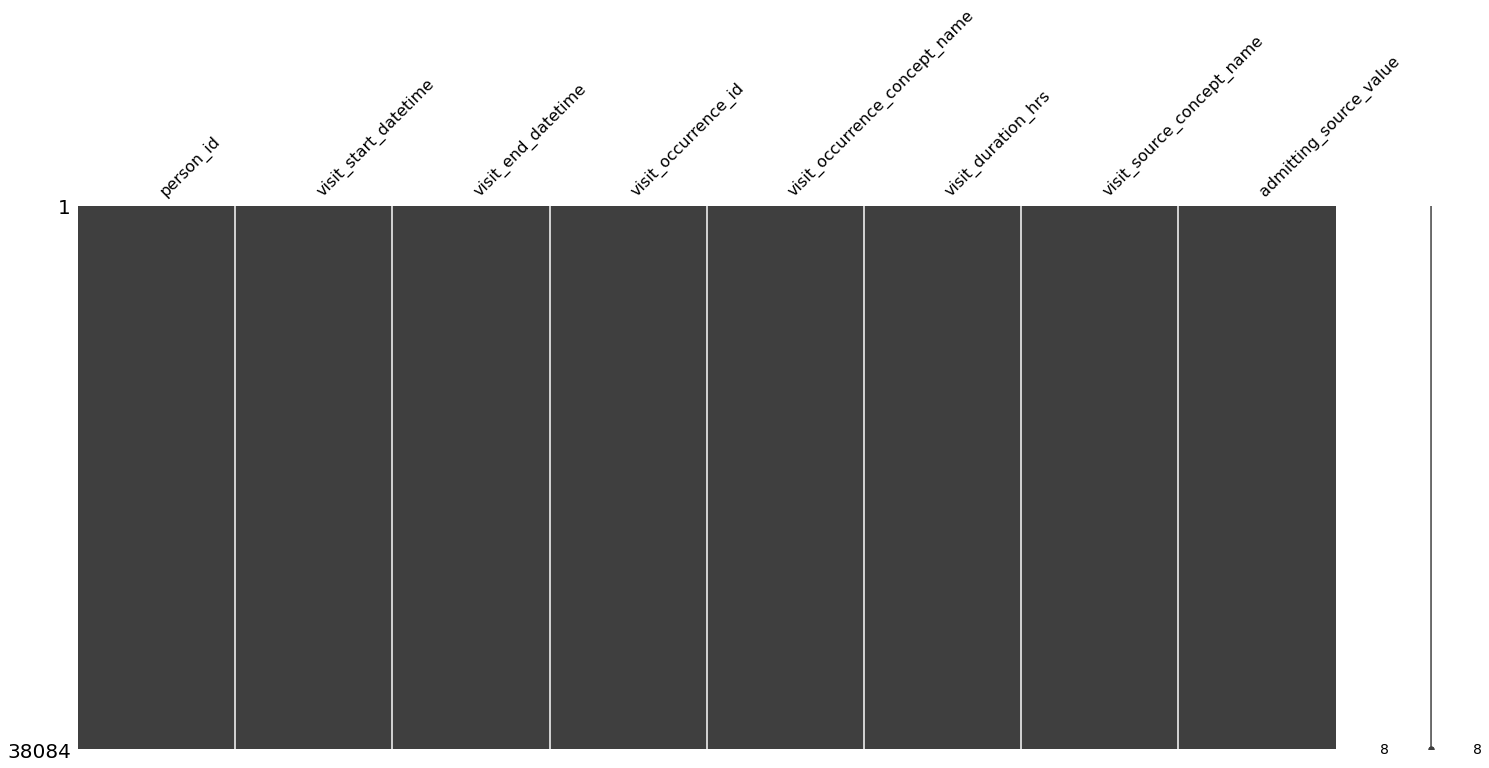

In [6]:
import missingno as msno

msno.matrix(staticDf)

<AxesSubplot:>

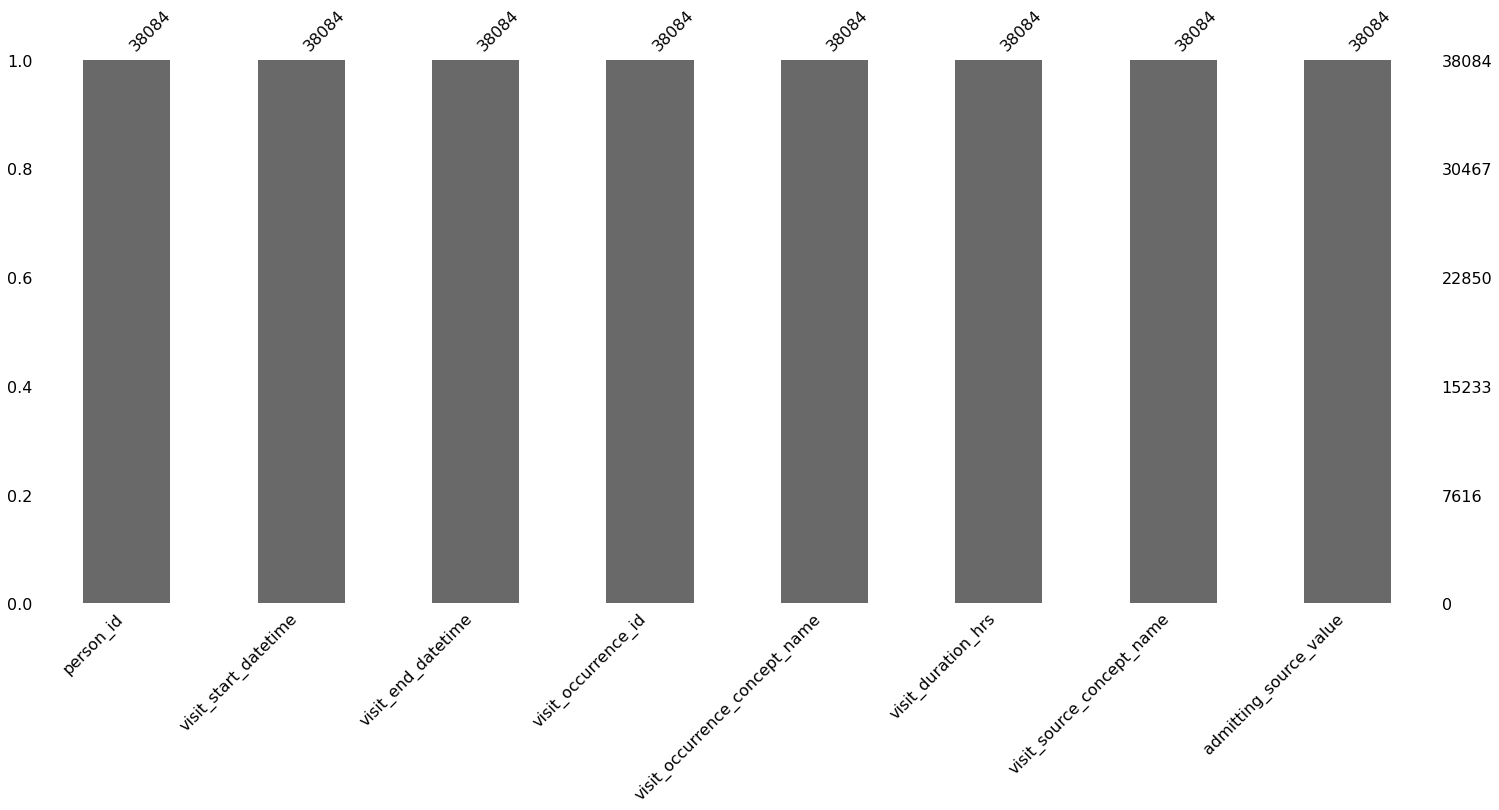

In [8]:
import missingno as msno

msno.bar(staticDf)

## Vitals data

### Read data

In [9]:
vitalsQuery = """select * from sepsis_icd.vitals;"""
vitalsDf = pd.read_sql_query(vitalsQuery, con)
vitalsDf

,visit_occurrence_id,person_id,measurement_datetime,unit_source_value,value_as_number,concept_name,rn
0,-914415209,-2146573171,2141-09-15 19:31:00,°F,97.6,Body temperature,1
1,-914415209,-2146573171,2141-09-16 00:00:00,°F,98.3,Body temperature,2
2,-914415209,-2146573171,2141-09-16 04:00:00,°F,97.6,Body temperature,3
3,-914415209,-2146573171,2141-09-16 08:00:00,°F,99.3,Body temperature,4
4,-914415209,-2146573171,2141-09-16 12:00:00,°F,100.1,Body temperature,5
...,...,...,...,...,...,...,...
23214903,741509696,2147343185,2113-08-23 13:01:00,mmHg,127.0,Systolic blood pressure by Noninvasive,98
23214904,741509696,2147343185,2113-08-23 14:01:00,mmHg,124.0,Systolic blood pressure by Noninvasive,99
23214905,741509696,2147343185,2113-08-23 14:01:00,mmHg,124.0,Systolic blood pressure by Noninvasive,100
23214906,741509696,2147343185,2113-08-23 15:01:00,mmHg,116.0,Systolic blood pressure by Noninvasive,101


### Missing data

<AxesSubplot:>

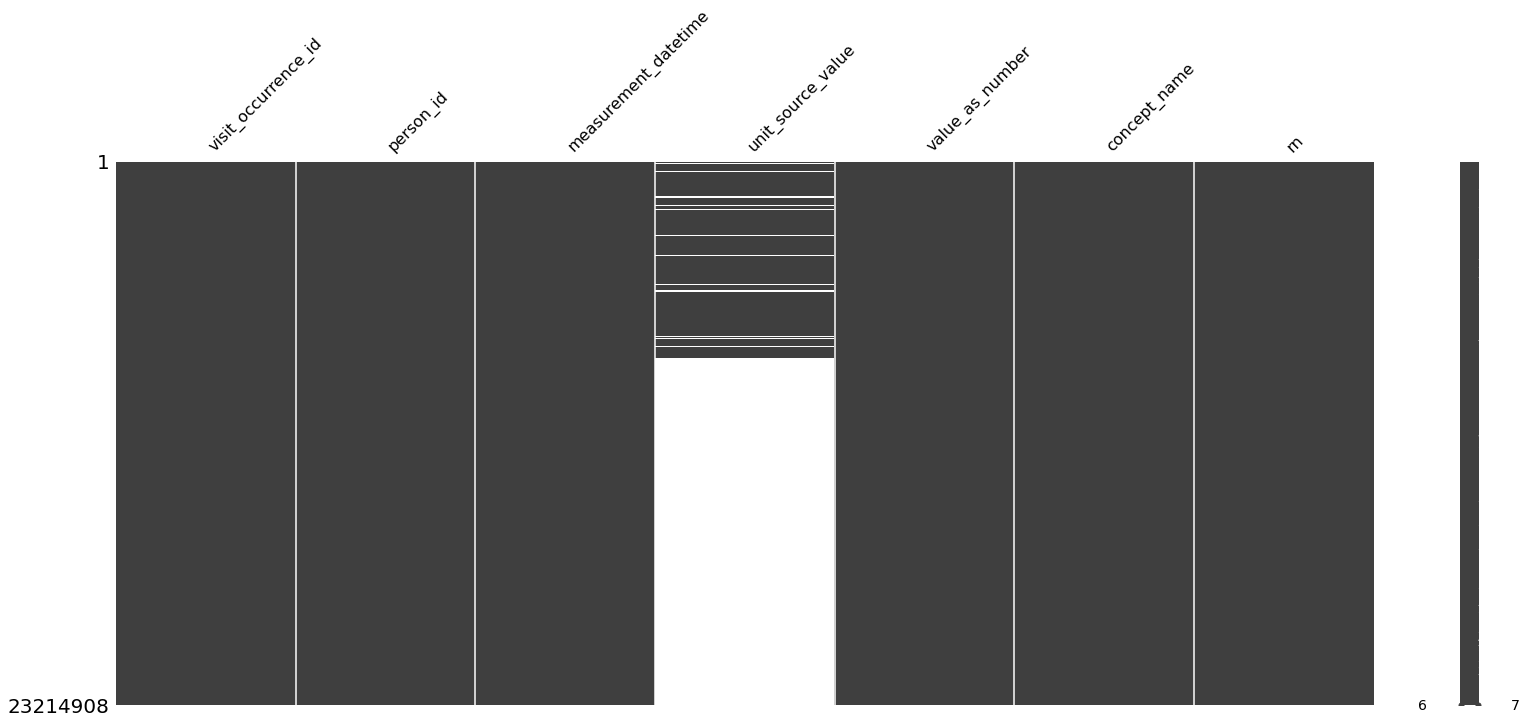

In [10]:
import missingno as msno

msno.matrix(vitalsDf)

<AxesSubplot:>

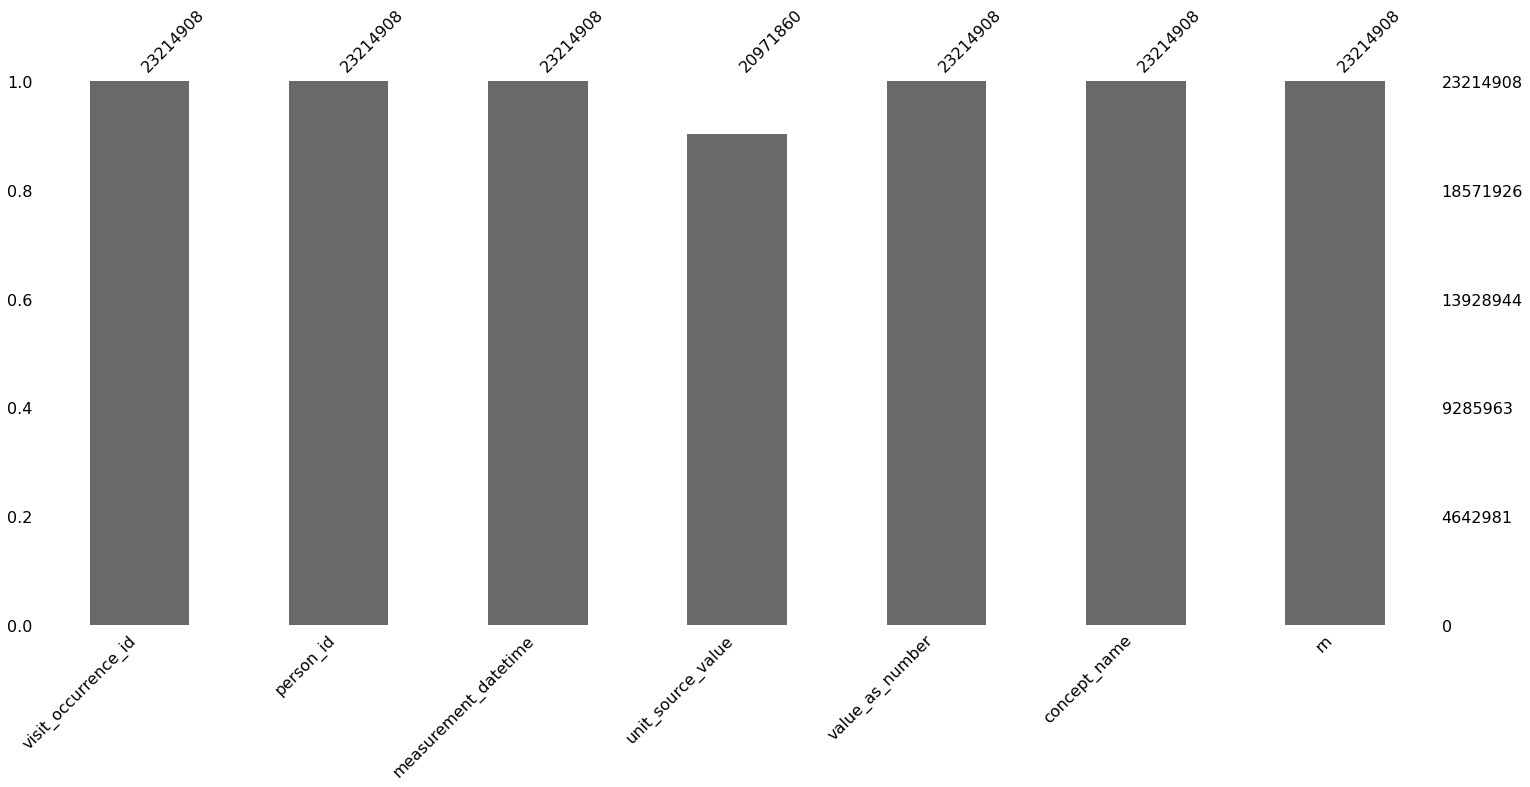

In [11]:
import missingno as msno

msno.bar(vitalsDf)

### Outliers

In [134]:
import numpy as np

def reject_outliers(df):
    data = df[df.value_as_number != 999999].value_as_number
    inx = data.sub(data.mean()).div(data.std()).abs().le(2)
    return df[inx]

#     Q1 = df['value_as_number'].quantile(0.25)
#     Q3 = df['value_as_number'].quantile(0.75)
#     IQR = Q3 - Q1

#     # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
#     filtered = df.query('(@Q1 - 1.5 * @IQR) <= value_as_number <= (@Q3 + 1.5 * @IQR)')
#     return filtered

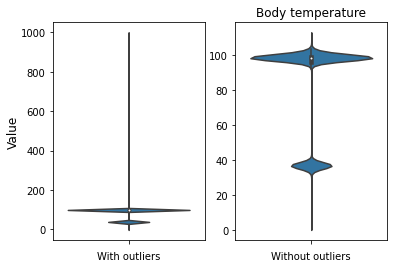

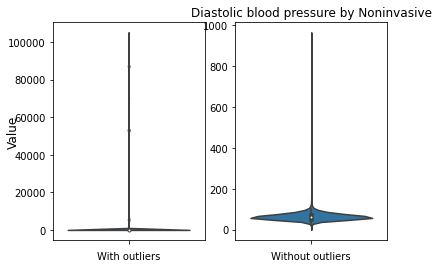

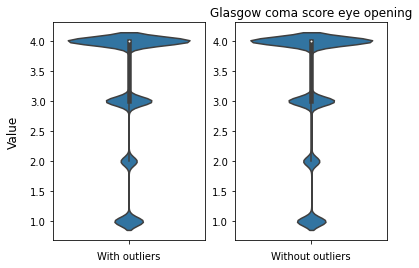

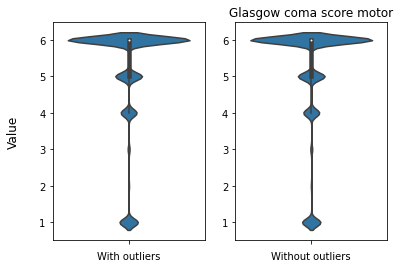

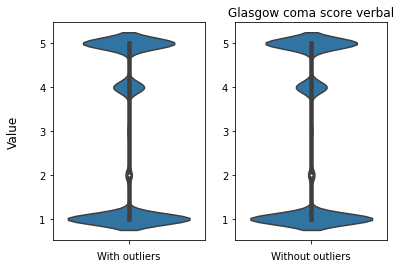

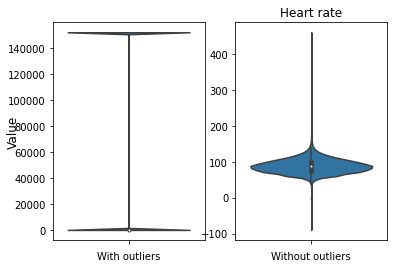

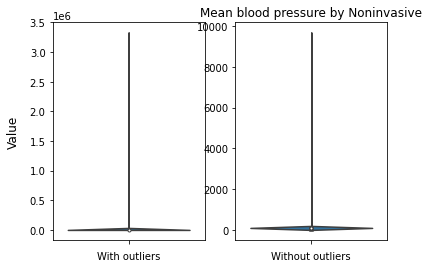

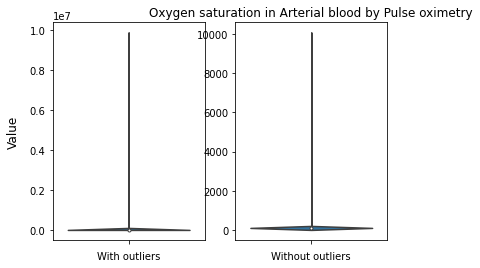

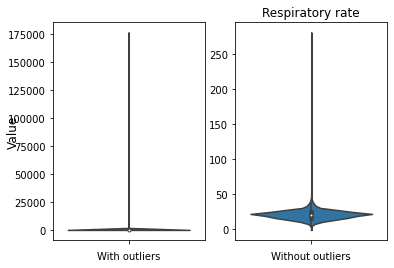

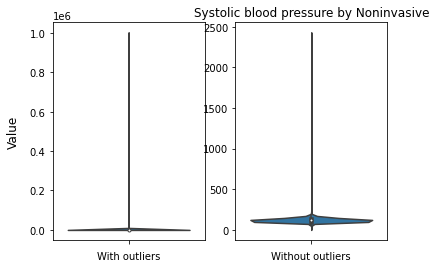

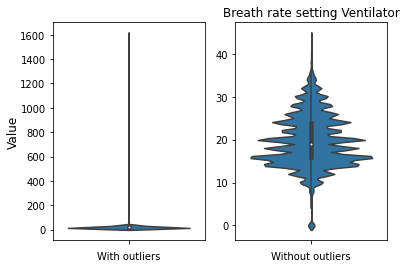

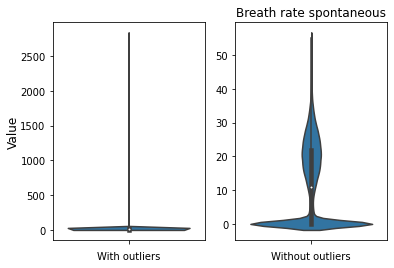

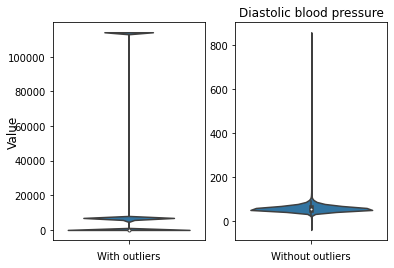

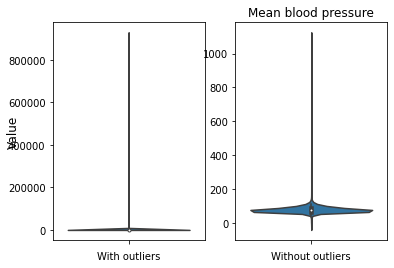

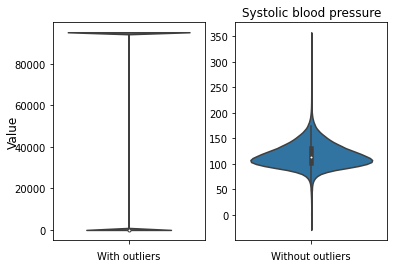

In [135]:
from matplotlib import pyplot as plt
import seaborn as sns

vitalsFilteredDf = pd.DataFrame(columns=vitalsDf.columns)

vitalsConcepts = vitalsDf.concept_name.unique()

for v in vitalsConcepts:

    vitalsValues = vitalsDf[vitalsDf.concept_name == v]
    vitalsValuesFiltered = reject_outliers(vitalsValues)

    vitalsFilteredDf = pd.concat([vitalsFilteredDf, vitalsValuesFiltered])

    fig, (ax1, ax2) = plt.subplots(1, 2)

    sns.violinplot(
        y = vitalsValues.value_as_number,
        ax=ax1
    )
    ax1.set_xlabel('With outliers')
    ax1.set_ylabel('')

    sns.violinplot(
        y = vitalsValuesFiltered.value_as_number,
        ax=ax2
    )
    ax2.set_xlabel('Without outliers')
    ax2.set_ylabel('')

    fig.supylabel('Value')
    plt.title(v)
    plt.show()

In [100]:
vitalsFilteredDf

,visit_occurrence_id,person_id,measurement_datetime,unit_source_value,value_as_number,concept_name,rn
0,-914415209,-2146573171,2141-09-15 19:31:00,°F,97.6,Body temperature,1
1,-914415209,-2146573171,2141-09-16 00:00:00,°F,98.3,Body temperature,2
2,-914415209,-2146573171,2141-09-16 04:00:00,°F,97.6,Body temperature,3
3,-914415209,-2146573171,2141-09-16 08:00:00,°F,99.3,Body temperature,4
4,-914415209,-2146573171,2141-09-16 12:00:00,°F,100.1,Body temperature,5
...,...,...,...,...,...,...,...
23214801,741509696,2147343185,2113-08-22 08:01:00,mmHg,107.0,Systolic blood pressure,60
23214802,741509696,2147343185,2113-08-22 09:00:00,mmHg,120.0,Systolic blood pressure,61
23214803,741509696,2147343185,2113-08-22 09:00:00,mmHg,120.0,Systolic blood pressure,62
23214804,741509696,2147343185,2113-08-22 10:00:00,mmHg,108.0,Systolic blood pressure,63


## Laboratory Measurements

### Read data

In [12]:
labsQuery = """select * from sepsis_icd.labs;"""
labsDf = pd.read_sql_query(labsQuery, con)
labsDf

,visit_occurrence_id,person_id,measurement_datetime,unit_source_value,value_as_number,concept_name,rn
0,-914415209,-2146573171,2141-09-16 04:26:00,mEq/L,26.0,Bicarbonate [Moles/volume] in Serum or Plasma,1
1,-914415209,-2146573171,2141-09-16 04:26:00,mEq/L,108.0,Chloride [Moles/volume] in Serum or Plasma,1
2,-914415209,-2146573171,2141-09-16 04:26:00,mg/dL,0.7,Creatinine [Mass/volume] in Serum or Plasma,1
3,-914415209,-2146573171,2141-09-16 04:26:00,mg/dL,74.0,Glucose [Mass/volume] in Serum or Plasma,1
4,-914415209,-2146573171,2141-09-16 04:26:00,g/dl,9.3,Hemoglobin [Mass/volume] in Blood,1
...,...,...,...,...,...,...,...
1414251,741509696,2147343185,2113-08-21 03:55:00,mEq/L,141.0,Sodium [Moles/volume] in Serum or Plasma,1
1414252,741509696,2147343185,2113-08-21 08:19:00,mEq/L,139.0,Sodium [Moles/volume] in Serum or Plasma,2
1414253,741509696,2147343185,2113-08-21 16:30:00,mEq/L,137.0,Sodium [Moles/volume] in Serum or Plasma,3
1414254,741509696,2147343185,2113-08-22 01:34:00,mEq/L,136.0,Sodium [Moles/volume] in Serum or Plasma,4


### Missing data

<AxesSubplot:>

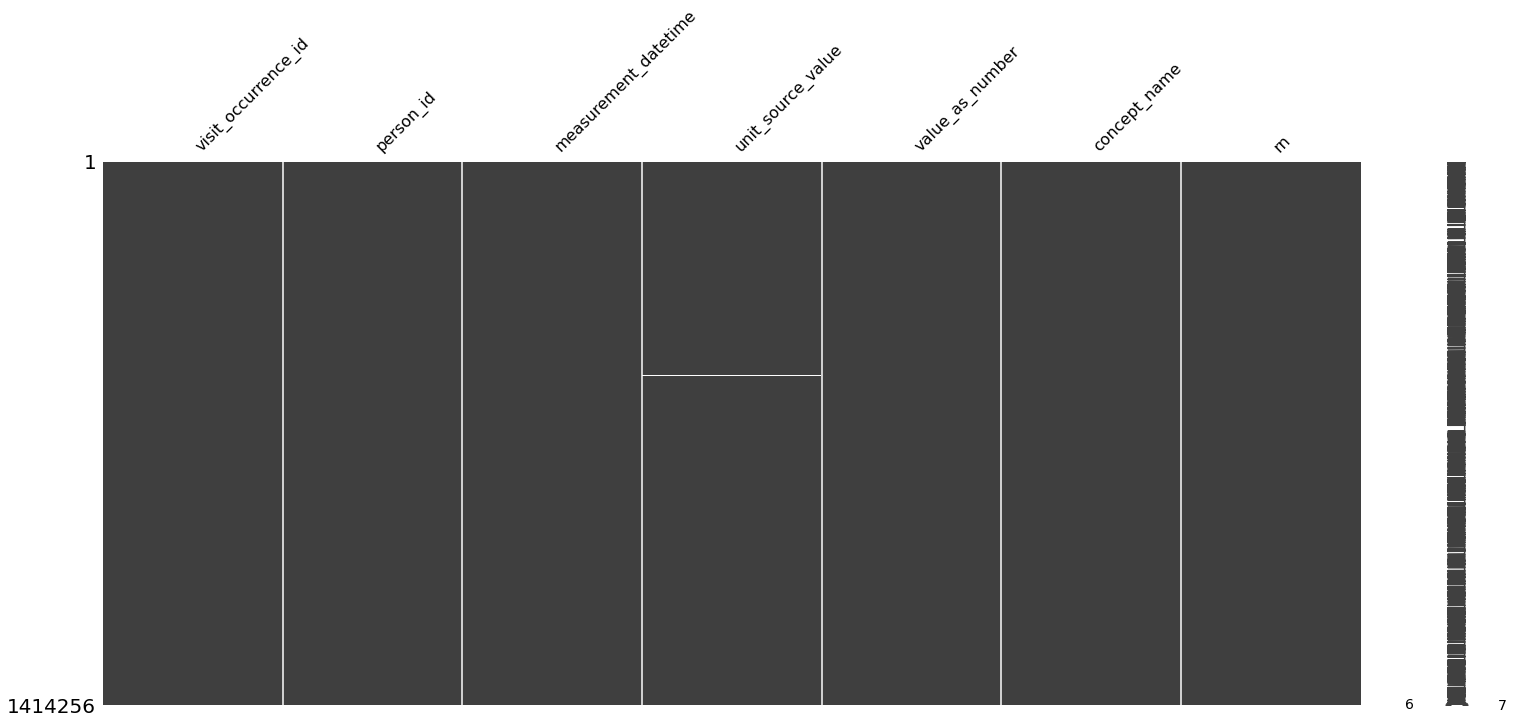

In [13]:
import missingno as msno

msno.matrix(labsDf)

<AxesSubplot:>

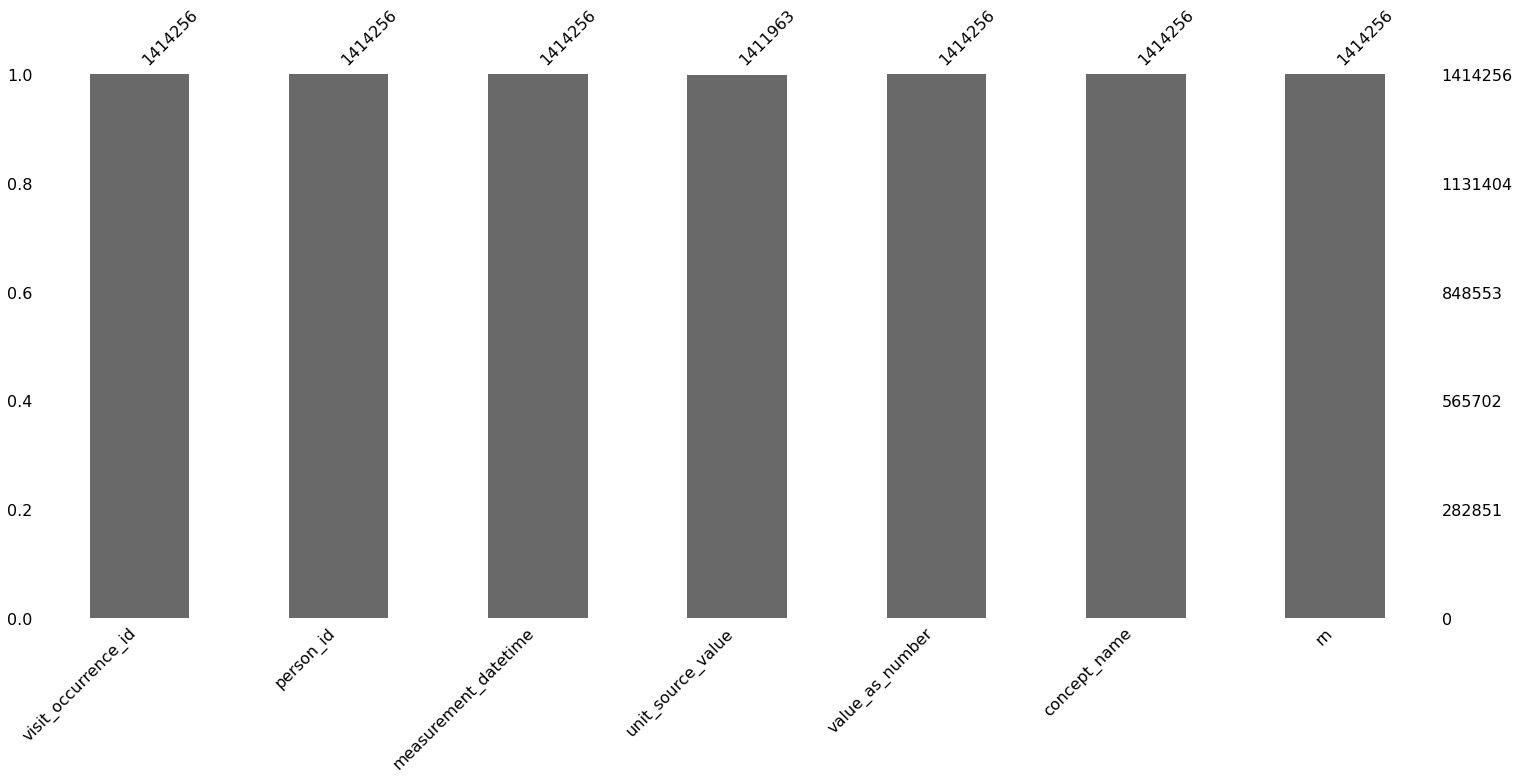

In [14]:
import missingno as msno

msno.bar(labsDf)

### Outliers

In [101]:
import numpy as np

def reject_outliers(df):
    data = df[df.value_as_number != 999999].value_as_number
    inx = data.sub(data.mean()).div(data.std()).abs().le(3)
    return df[inx]

#     Q1 = df['value_as_number'].quantile(0.25)
#     Q3 = df['value_as_number'].quantile(0.75)
#     IQR = Q3 - Q1

#     # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
#     filtered = df.query('(@Q1 - 1.5 * @IQR) <= value_as_number <= (@Q3 + 1.5 * @IQR)')
#     return filtered

In [132]:
reject_outliers(labsValues)

,visit_occurrence_id,person_id,measurement_datetime,unit_source_value,value_as_number,concept_name,rn
1,-914415209,-2146573171,2141-09-16 04:26:00,mEq/L,108.0,Chloride [Moles/volume] in Serum or Plasma,1
25,-97846757,-2146331340,2116-05-21 04:28:00,mEq/L,119.0,Chloride [Moles/volume] in Serum or Plasma,1
26,-97846757,-2146331340,2116-05-21 07:56:00,mEq/L,118.0,Chloride [Moles/volume] in Serum or Plasma,2
27,-97846757,-2146331340,2116-05-21 11:56:00,mEq/L,113.0,Chloride [Moles/volume] in Serum or Plasma,3
28,-97846757,-2146331340,2116-05-21 15:43:00,mEq/L,116.0,Chloride [Moles/volume] in Serum or Plasma,4
...,...,...,...,...,...,...,...
1414225,741509696,2147343185,2113-08-21 03:55:00,mEq/L,113.0,Chloride [Moles/volume] in Serum or Plasma,1
1414226,741509696,2147343185,2113-08-21 08:19:00,mEq/L,114.0,Chloride [Moles/volume] in Serum or Plasma,2
1414227,741509696,2147343185,2113-08-21 16:30:00,mEq/L,112.0,Chloride [Moles/volume] in Serum or Plasma,3
1414228,741509696,2147343185,2113-08-22 01:34:00,mEq/L,109.0,Chloride [Moles/volume] in Serum or Plasma,4


In [131]:
labsValues

,visit_occurrence_id,person_id,measurement_datetime,unit_source_value,value_as_number,concept_name,rn
1,-914415209,-2146573171,2141-09-16 04:26:00,mEq/L,108.0,Chloride [Moles/volume] in Serum or Plasma,1
25,-97846757,-2146331340,2116-05-21 04:28:00,mEq/L,119.0,Chloride [Moles/volume] in Serum or Plasma,1
26,-97846757,-2146331340,2116-05-21 07:56:00,mEq/L,118.0,Chloride [Moles/volume] in Serum or Plasma,2
27,-97846757,-2146331340,2116-05-21 11:56:00,mEq/L,113.0,Chloride [Moles/volume] in Serum or Plasma,3
28,-97846757,-2146331340,2116-05-21 15:43:00,mEq/L,116.0,Chloride [Moles/volume] in Serum or Plasma,4
...,...,...,...,...,...,...,...
1414225,741509696,2147343185,2113-08-21 03:55:00,mEq/L,113.0,Chloride [Moles/volume] in Serum or Plasma,1
1414226,741509696,2147343185,2113-08-21 08:19:00,mEq/L,114.0,Chloride [Moles/volume] in Serum or Plasma,2
1414227,741509696,2147343185,2113-08-21 16:30:00,mEq/L,112.0,Chloride [Moles/volume] in Serum or Plasma,3
1414228,741509696,2147343185,2113-08-22 01:34:00,mEq/L,109.0,Chloride [Moles/volume] in Serum or Plasma,4


In [124]:
labsValues = labsDf[labsDf.concept_name == 'Chloride [Moles/volume] in Serum or Plasma']

In [130]:
labsValues[labsValues.value_as_number == 999999]

,visit_occurrence_id,person_id,measurement_datetime,unit_source_value,value_as_number,concept_name,rn
192586,201468448,-1542512826,2140-03-28 16:25:00,mEq/L,999999.0,Chloride [Moles/volume] in Serum or Plasma,6
238700,1418088026,-1395096166,2182-12-02 18:23:00,mEq/L,999999.0,Chloride [Moles/volume] in Serum or Plasma,8
272622,-1544436819,-1274057290,2197-04-14 16:02:00,mEq/L,999999.0,Chloride [Moles/volume] in Serum or Plasma,1
331015,953975262,-1114101569,2144-07-03 13:26:00,None,999999.0,Chloride [Moles/volume] in Serum or Plasma,8
532568,418125910,-541754315,2138-10-20 07:20:00,mEq/L,999999.0,Chloride [Moles/volume] in Serum or Plasma,2
1090614,2006783368,1175983577,2194-03-10 19:00:00,mEq/L,999999.0,Chloride [Moles/volume] in Serum or Plasma,10
1142101,1654144751,1319743903,2142-11-11 02:39:00,mEq/L,999999.0,Chloride [Moles/volume] in Serum or Plasma,2
1179074,-1953993398,1452751414,2125-03-12 16:31:00,None,999999.0,Chloride [Moles/volume] in Serum or Plasma,4
1204952,-147357518,1533414768,2173-02-12 12:40:00,None,999999.0,Chloride [Moles/volume] in Serum or Plasma,5
1229476,946032293,1597403970,2130-08-28 07:27:00,None,999999.0,Chloride [Moles/volume] in Serum or Plasma,2


In [126]:
labsValues[labsValues.value_as_number < 100].value_as_number.std()

3.962128521047209

In [127]:
labsValues[labsValues.value_as_number < 100].value_as_number.mean()

95.11953001814143

In [114]:
labsDf.concept_name.unique()

array(['Bicarbonate [Moles/volume] in Serum or Plasma',
       'Chloride [Moles/volume] in Serum or Plasma',
       'Creatinine [Mass/volume] in Serum or Plasma',
       'Glucose [Mass/volume] in Serum or Plasma',
       'Hemoglobin [Mass/volume] in Blood',
       'Potassium [Moles/volume] in Serum or Plasma',
       'Sodium [Moles/volume] in Serum or Plasma'], dtype=object)

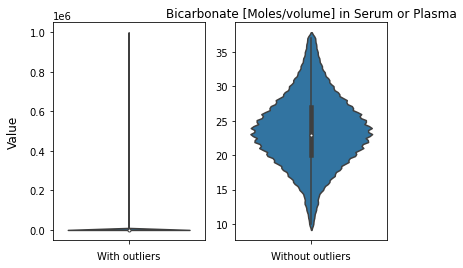

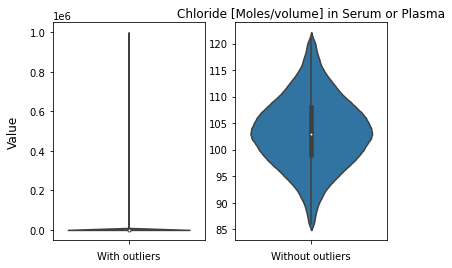

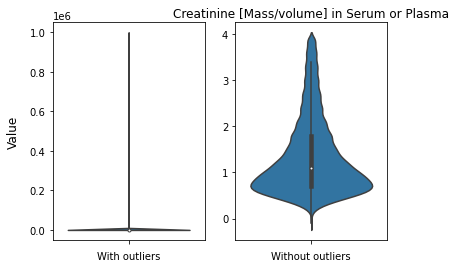

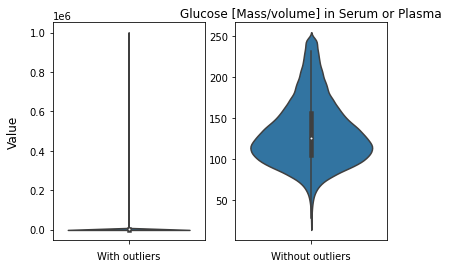

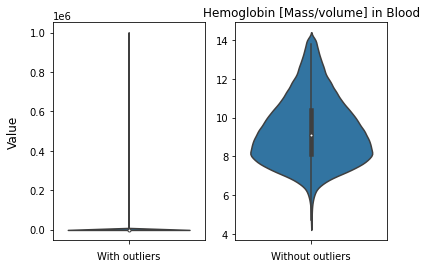

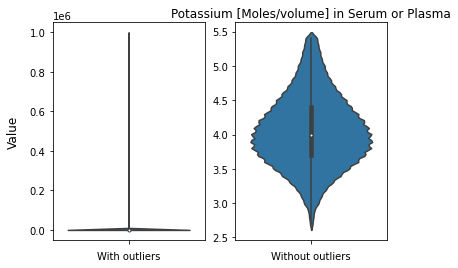

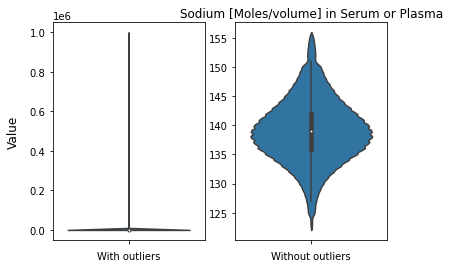

In [133]:
from matplotlib import pyplot as plt
import seaborn as sns

labsFilteredDf = pd.DataFrame(columns=labsDf.columns)

labConcepts = labsDf.concept_name.unique()

for v in labConcepts:

    labsValues = labsDf[labsDf.concept_name == v]
    labsValuesFiltered = reject_outliers(labsValues)

    labsFilteredDf = pd.concat([labsFilteredDf, labsValuesFiltered])

    fig, (ax1, ax2) = plt.subplots(1, 2)

    sns.violinplot(
        y = labsValues.value_as_number,
        ax=ax1
    )
    ax1.set_xlabel('With outliers')
    ax1.set_ylabel('')

    sns.violinplot(
        y = labsValuesFiltered.value_as_number,
        ax=ax2
    )
    ax2.set_xlabel('Without outliers')
    ax2.set_ylabel('')

    fig.supylabel('Value')
    plt.title(v)
    plt.show()